In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.Net import Final_Network
from Utilities.create_data import create_new
from Utilities.loss_and_accuracies import data_loss_classification, accuracy_classification
from Utilities.manifold_regularization import manifold_classification
from Utilities.optimize_layerwise import optimize
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [2]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [3]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 10
    activation        = 'elu'
    regularization    = 0.001
    manifold          = 0.006
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 1000
    num_epochs        = 2
    
    num_networks      = 3
    

In [4]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 1
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [5]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
ListWrapper([784, 10, 10, 10])
Initial Losses:
Training Set: Loss: 1.469e-01
Test Set: Accuracy: 0.145

Beginning Training
            Epoch 0            
MNIST_FC_L1_mhl3_hl10_rpt001_nTOL4_eTOL4_b1000_e2
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 48 batches of size 1000:
Model: "fc_layerwise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  110       
_________________________________________________________________
upsampling_layer (Dense)     multiple                  7850      
_________________________________________________________________
classification_layer (Dense) multiple                  110       
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
_________________________________________________________________
Time per Batch: 0.06
Ti

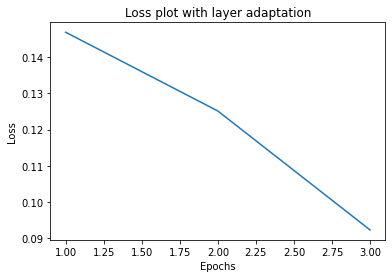

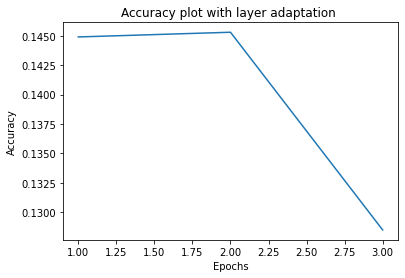

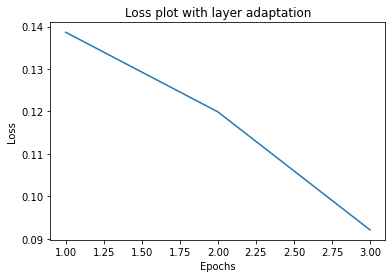

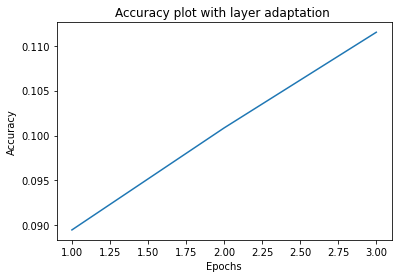

In [6]:
if __name__ == "__main__":     

    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    

    
    for i in range(1,hyperp.num_networks):
    
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
            #=== GPU Settings ===#
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
        os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
        if run_options.use_L1 == 0:
            kernel_regularizer = None
            bias_regularizer = None  
        else:
            kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)

        data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp, run_options, data_input_shape, label_dimensions,i)
        
        #=== Construct Validation Set and Batches ===# 
        data_and_labels_train, data_and_labels_val, data_and_labels_test,\
        num_data_train, num_data_val, num_data_test,\
        num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
        = form_train_val_test_batches(data_train, labels_train, \
                                  data_test, labels_test, \
                                  hyperp.batch_size, new_label, run_options.random_seed)
        
        

        NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,
                      kernel_regularizer, bias_regularizer)    
    
    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        optimize(hyperp, run_options, file_paths, NN, data_loss_classification, accuracy_classification, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape)   
        
        plot_fig(hyperp, run_options, file_paths,i)
        
        

        
        
        
        
        
        
        
        

In [10]:
import random
random.randint(1,5)

3

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets
kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

In [8]:
Network=Final_Network(hyperp, run_options, data_input_shape, label_dimensions,
                      kernel_regularizer, bias_regularizer) 

ListWrapper([28, 10, 10, 10])


In [9]:
Network.load_weights("WEIGHTS"+'/'+"model_weights1")

In [10]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_test = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(batch_size)
num_batches_test = len(list(data_and_labels_test))

#=== Partitioning Out Validation Set and Constructing Batches ===#
current_num_data_train = num_data_train
num_data_train = int(0.8 * num_data_train)
num_data_val = current_num_data_train - num_data_train
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [23]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

In [24]:
labels=tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [25]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,labels)).shuffle(num_data_train, seed=random_seed)

In [26]:
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [32]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train.enumerate():
    batch=batch_num
    batch_data_train = batch_data_train
    batch_labels_train=batch_labels_train
    lab=labels

In [36]:
lab


<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [20]:
y_true = tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [21]:
y_true

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [37]:
np.mean(tf.keras.losses.mean_squared_error(new_one, val[0:dimension[0]-1]))

1.9269863

array([4, 6, 6, ..., 7, 2, 5])

In [19]:

x_train_new = batch_data_train[batch_labels_train == 1]
batch_pred_train,val=NN(x_train_new)



In [16]:
y_true = tf.one_hot(tf.cast(y_true,tf.int64), label_dimensions, dtype=tf.float32)

In [45]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.6097095>

In [48]:
np.linalg.norm(val[0]-val[1])

2.567157